<a href="https://colab.research.google.com/github/dnguyend/FAERS/blob/master/DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction
This notebook is the main interactive tool to provide analysis using the Adverse Event database. The diagram and the steps are summarized in the main project README page. This notebook runs on google colab, so you can run the examples on the cloud instead of your home machine.

We first download clone the project to your colab space then create a data directory:

In [1]:
!git clone https://github.com/dnguyend/FAERS.git
import sys
# add the package to execution path
sys.path.insert(1, "FAERS")
# make data dir
!mkdir data

Cloning into 'FAERS'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 6), reused 17 (delta 3), pack-reused 0
Unpacking objects: 100% (24/24), done.


We can check quickly the package is downloaded and a data directory is created. If you need to run again you may get error messages that directory may be not empty. You can run !rm -rf on the directories then reload.

In [28]:
!ls
!echo "check the FAERS DIRECTORY"
!ls FAERS
sys.path.insert(1, "FAERS")

data  FAERS  sample_data
check the FAERS DIRECTORY
analyze_cholesterol.py	demo_analyze.py     FAERS_ERD.PNG  LICENSE
cfg			download_script.py  faers_lib	   README.md
faers_ascii_2019Q4  faers_ascii_2019Q4.zip


The main library is faers_lib, which is located one directory down from the main directory FAERS. At this point it contains some functions to download/extract zip file from the website (module faers_lib.download) and some functions to do analysis (module fayers_lib.analyze). Download typically takes a few minutes. We will load one quarter then test the data. (If we want to load all quarter run load_all_files - but it may take a lot of time and you may exceed your Colab allocation.)

In [19]:
# run the following code:
from faers_lib.download import load_all_files, download_one, extract_all_files
""" to load Q4 2019"""
download_one(2019, 4)
extract_all_files()

File exists ./data/faers_ascii_2019Q4.zip, skip
Extracting ./data/faers_ascii_2019Q4.


In [21]:
!ls data/faers_ascii_2019Q4

ascii  deleted	FAQs.pdf  Readme.pdf


Now we can load a few common libraries and load the 7 FAERS files to 7 data frames in all_frames:


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import faers_lib.analyze
from faers_lib.analyze import load_one_quarter, display_frame, bdisplay
faers_lib.analyze.display_mode = 'HTML'  # this will set display_frame to display data frame in HTML format
from IPython.core.display import display, HTML
%matplotlib inline

In [0]:
all_frames = load_one_quarter(2019, 4)
print(all_frames.keys())

Now examine the data: show the list of tables, get the last rows of reaction, get 1 row of demographic.

In [29]:
display_frame(all_frames['reaction'].tail())
display_frame(all_frames['indication'].tail())
bdisplay("demographic line")
print(all_frames['demographic'].iloc[0])
bdisplay("drug line")
print(all_frames['drug'].iloc[0])


dict_keys(['demographic', 'drug', 'indication', 'outcome', 'reaction', 'report_sources', 'therapy'])


,primaryid,caseid,pt,drug_rec_act
1359917,99974143,9997414,Type 2 diabetes mellitus,NaN
1359918,99974513,9997451,Type 2 diabetes mellitus,NaN
1359919,99975493,9997549,Type 2 diabetes mellitus,NaN
1359920,99990904,9999090,Nail growth abnormal,NaN
1359921,99990904,9999090,Psoriasis,NaN


,primaryid,caseid,indi_drug_seq,indi_pt
1146933,99975493,9997549,1,Blood cholesterol increased
1146934,99975493,9997549,2,Blood triglycerides increased
1146935,99975493,9997549,3,Hypertension
1146936,99990904,9999090,2,Neuralgia
1146937,99990904,9999090,3,Pain


demographic line
primaryid                          100046572
caseid                              10004657
caseversion                                2
i_f_code                                   F
event_dt                 2012-07-31 00:00:00
mfr_dt                   2019-10-28 00:00:00
init_fda_dt              2014-03-12 00:00:00
fda_dt                   2019-10-30 00:00:00
rept_cod                                 EXP
auth_num                                 NaN
mfr_num             US-PFIZER INC-2014065269
mfr_sndr                              PFIZER
lit_ref                                  NaN
age                                       71
age_cod                                   YR
age_grp                                  NaN
sex                                        F
e_sub                                      Y
wt                                     81.63
wt_cod                                    KG
rept_dt                  2019-10-30 00:00:00
to_mfr                                

In theory we can use the above procedure to load every quarter data, but older data seems to be in different format so the code may not work. For some quarters data may have characters unreadable by read_csv. We had to edit the file to remove the character.

We also load a file where we pull data from the PDF description of the field to computer-readable format. We do some sanity checks here and notice some small issues with data - to be discuss later.


In [30]:
 # this file explain the abbreviations from the fields.
import json
with open("./FAERS/cfg/extra.json") as jf:
    extra_dict = json.load(jf)
print(extra_dict)


{'OUTCOME.OUTC_COD': {'DE': 'Death', 'LT': 'Life-Threatening', 'HO': 'Hospitalization - Initial or Prolonged', 'DS': 'Disability', 'CA': 'Congenital Anomaly', 'RI': 'Required Intervention to Prevent Permanent        Impairment/Damage', 'OT': 'Other Serious (Important Medical Event)'}, 'THERAPY.DUR_COD': {'YR': 'Years', 'MON': 'Months', 'WK': 'Weeks', 'DAY': 'Days', 'HR': 'Hours', 'MIN': 'Minutes', 'SEC': 'Seconds'}, 'REPORT_SOURCES.CODE': {'FGN': 'Foreign', 'SDY': 'Study', 'LIT': 'Literature', 'CSM': 'Consumer', 'HP': 'Health Professional', 'UF': 'User Facility', 'CR': 'Company Representative', 'DT': 'Distributor', 'OTH': 'Other'}, 'DEMOGRAPHIC.WT_COD': {'KG': 'Kilograms', 'LBS': 'Pounds', 'GMS': 'Grams'}, 'DEMOGRAPHIC.AGE_GRP': {'N': 'Neonate', 'I': 'Infant', 'C': 'Child', 'T': 'Adolescent', 'A': 'Adult', 'E': 'Elderly'}, 'DEMOGRAPHIC.AGE_COD': {'DEC': 'DECADE', 'YR': 'YEAR', 'MON': 'MONTH', 'WK': 'WEEK', 'DY': 'DAY', 'HR': 'HOUR'}, 'DRUG.DOSE_FREQ': {'1X': 'Once or one time', 'BID': 

Checking severity level of outcoume, balance of sex in incidents:

,primaryid
outc_cod,
OT,118413
HO,75673
DE,33778
LT,7792
DS,5139
CA,998
RI,481


,0,1
0,DE,Death
1,LT,Life-Threatening
2,HO,Hospitalization - Initial or Prolonged
3,DS,Disability
4,CA,Congenital Anomaly
5,RI,Required Intervention to Prevent Permanent Impairment/Damage
6,OT,Other Serious (Important Medical Event)


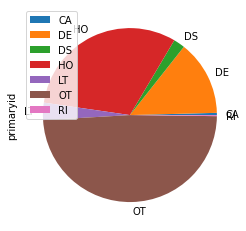

In [57]:
ocnt = all_frames['outcome'][['outc_cod', 'primaryid']].groupby('outc_cod').count()
bdisplay("DISTRIBUTION OF OUTCOME")
display_frame(ocnt.sort_values(by='primaryid', ascending=False))
ocnt.plot.pie(y='primaryid')
ocnt = None
display_frame(pd.DataFrame(np.array([(a, extra_dict['OUTCOME.OUTC_COD'][a]) for a in extra_dict['OUTCOME.OUTC_COD']])))

,primaryid
sex,
F,187994
M,121604
UNK,92


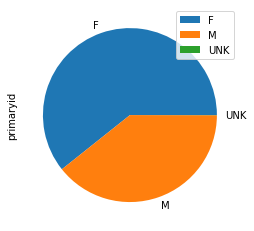

In [56]:
bdisplay("REPORTING EVENTS BY SEX")
sxcnt = all_frames['demographic'][['sex', 'primaryid']].groupby('sex').count()
display_frame(sxcnt.sort_values(by='primaryid', ascending=False))
sxcnt.plot.pie(y='primaryid')
sxcnt = None

In [60]:
# We found an issue with data: some therapy start_dt is later than end_dt
therapy = all_frames['therapy']
bdisplay("There are %d instances where therapy start date is after end date" % therapy.loc[therapy.start_dt > therapy.end_dt].shape[0])
therapy.loc[therapy.start_dt > therapy.end_dt].head()

,primaryid,caseid,dsg_drug_seq,start_dt,end_dt,dur,dur_cod
535,100717436,10071743,12,2013-12-03,2013-01-02,NaN,NaN
536,100717436,10071743,13,2013-12-03,2013-01-02,NaN,NaN
1080,101596593,10159659,1,2011-07-26,2011-01-01,NaN,NaN
3244,104144313,10414431,1,2013-02-07,2013-01-02,NaN,NaN
3245,104144313,10414431,2,2013-02-07,2013-01-02,NaN,NaN


### Analyzing reaction by country.
To analyze reaction by country, we need to join the data frames <b>reaction</b> and <b>demographic</b>. In practice, it is probably also important to view reaction <b>for one drug </b>accross different countries. But first, we show top reactions per country accross all reporting events. The following show number of reporting per country for the top 4 countries

In [61]:
demo = all_frames['demographic']
reaction = all_frames['reaction'][['primaryid', 'pt']]
rcnt = pd.merge(demo, reaction, on='primaryid')[['primaryid', 'occr_country', 'pt']].groupby(['occr_country', 'pt']).count()
cntr_cnt = rcnt.reset_index().groupby(by='occr_country').sum()
bdisplay('Tot number of countries is %d. These are the top countries' % cntr_cnt.shape[0])
display_frame(cntr_cnt.sort_values(by='primaryid', ascending=False).head())
rcnt = None
cntr_cnt = None

,primaryid
occr_country,
US,714408
CA,72211
GB,36065
JP,33313
FR,26259


### Analyzing by drug and country
In the first step we get the list of drugs with a lot of events reported. The numbers of reported events per drug differ.
Some drugs has many reported events, while some has just a few. We will sort drug by number of reported events, then provide a GUI to select a drug and view its event per distribution. The dataframe <b>esort</b> sort drugs by reported events.
We note the drugs with top number of events has 19k of events,
while the 50%tile only has small number of events. The 500th drug in the list (sorted in descending order) has around 600 events.


,event_cnt
count,49604.000000
mean,24.884949
std,263.338061
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,17837.000000


,event_cnt
drugname,
ENBREL,17837
REVLIMID,17207
HUMIRA,16989
XARELTO,14520
XOLAIR,12053
AMPYRA,10887
SENSIPAR,10181
PREDNISONE.,9262
ASPIRIN.,8427


,event_cnt
drugname,
QVAR,451
BUDESONIDE.,449
YERVOY,448
CORTISONE,447
SOVALDI,446
LATANOPROST.,446
NASONEX,446
SERETIDE,445
VIEKIRAX,444


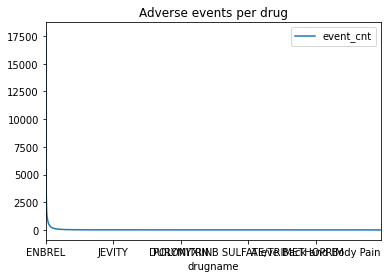

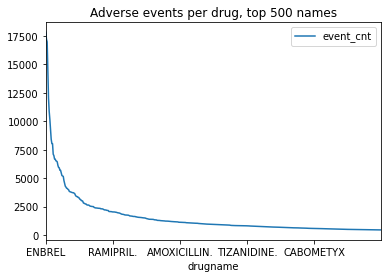

In [62]:
%matplotlib inline
dr = all_frames['drug']
# Adverse events by drug
e_by_drug = dr[['drugname', 'primaryid']].groupby(
    'drugname').count()
e_by_drug.rename(columns={'primaryid': 'event_cnt'}, inplace=True)
display_frame(e_by_drug.describe())
esort = e_by_drug.sort_values(by='event_cnt', ascending=False)
display(HTML("<b>DRUG WITH TOP NUMBER OF EVENTS</b>"))
display_frame(esort.head(10))
esort.plot(title="Adverse events per drug")
drug_idx = 500
# try a middle of the pack

esort[:drug_idx].plot(title="Adverse events per drug, top %d names" % drug_idx)
display_frame(esort.iloc[drug_idx:drug_idx+10])

The following code shows a GUI to select a drug with many events (top of <b>esort</b>). It then show breakdown of reporting events by country and reported type. Note that since we have several reactions per report, the report count here is different from above


In [40]:
from ipywidgets import interact
import numpy as np
import pandas as pd

show_top = 50
cntr_cutoff = 6
cntry_field = 'occr_country'
# cntry_field = 'reporter_country'
ddr_agg = faers_lib.analyze.gen_drug_demo_react_agg(all_frames)
bdisplay("CHANGE THE DROP DOWN BOX TO SELECT A DIFFERENT DRUG")
def analyze_one_drug_by_country(
        ddr_agg, one_drug, cntry_field='occr_country',
        show_top=10):
    """Summarizing AE data on one drug by country.
    We can choose eiither occr_country or reporter_country
    """
    display(HTML('<b>Reporting on %s for %s by country and reaction</b>' % (
        cntry_field, one_drug)))
    data = ddr_agg.loc[
        ddr_agg.drugname == one_drug]

    by_cntry_tbl = data[['primaryid', cntry_field]].groupby(
        by=[cntry_field]).count().sort_values(
            by='primaryid', ascending=False)
    by_cntry_tbl.rename(columns={'primaryid': 'cnt'}, inplace=True)
    display_frame(by_cntry_tbl.head(show_top))
    display(HTML("TOP EVENTS BY COUNTRY:"))
    for c in by_cntry_tbl.index[:5]:
        react_by_cntry = data.loc[data[cntry_field] == c][
            [cntry_field, 'pt', 'primaryid']].groupby(
                [cntry_field, 'pt']).count().sort_values(
                    by=['primaryid'], ascending=False)
        react_by_cntry.rename(columns={'primaryid': 'cnt'}, inplace=True)
        display_frame(react_by_cntry.head(show_top))

def update_country(drugname):
    ddr2 = ddr_agg.loc[ddr_agg.drugname == drugname]
    ctry_dist = ddr2[['primaryid', cntry_field]].groupby(
        by=cntry_field).count().sort_values(by="primaryid", ascending=False)
    ctry_dist.rename(columns={'primaryid': 'cnt'}, inplace=True)
    ctry_dist.reset_index(inplace=True)
    display(HTML("TOTAL REPORTS PER DRUG - DISTRIBUTION/TOP COUNTRIES"))
    display_frame(ctry_dist.describe().loc[['count', 'mean', '25%', '50%', '75%', 'max']].T)    
    display_frame(ctry_dist.head())

    if ctry_dist.shape[0] > cntr_cutoff:
        ctry_dist.iloc[6:, 0] = 'OTHER'
    
    analyze_one_drug_by_country(
        ddr_agg, drugname, cntry_field=cntry_field, show_top=cntr_cutoff)
    nsp_idx = np.where(ctry_dist[cntry_field] == 'COUNTRY NOT SPECIFIED')[0]
    if nsp_idx.shape[0] > 0:
        ctry_dist.iloc[nsp_idx, 0] = 'OTHER'
    ctry_dist.groupby(by=cntry_field).sum().plot.pie(y="cnt")
interact(update_country, drugname=esort.index[:show_top])

interactive(children=(Dropdown(description='drugname', options=('REVLIMID', 'PREDNISONE.', 'HUMIRA', 'CIMZIA',…

<function __main__.update_country>

# ANALYZING BY DISEASE
Similarly we can analyze by disease area by drug. First we find a list of drugs that is used to treat several diseases, then show a GUI where we pick a drug, show the diseases and the reaction. There are <b>TWO</b> dropdown box where we can choose <b>DRUG</b> and <b>indication</b>, and view distribution of reactions.

,indi_pt
drugname,
PREDNISONE.,596
LYRICA,497
PREDNISOLONE.,417
DEXAMETHASONE.,362
METHYLPREDNISOLONE.,317


,count,mean,std,min,25%,50%,75%,max
indi_pt,47894.0,3.059966,9.796288,1.0,1.0,1.0,2.0,596.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbc0cdc26d8>]],
      dtype=object)

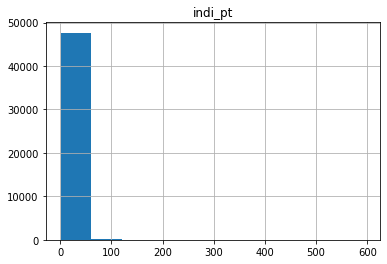

In [41]:
# look for some drug use for treatment of several diseases:
indication = all_frames['indication']
dr = all_frames['drug']
dr_de_indication_fr = pd.merge(
    ddr_agg, indication,
    how='inner', left_on=('primaryid', 'drug_seq'),
    right_on=('primaryid', 'indi_drug_seq'))
i_drug_name = pd.merge(
    dr[['primaryid', 'drug_seq', 'drugname']],
    indication[['primaryid', 'indi_drug_seq', 'indi_pt']],
    how='inner', left_on=['primaryid', 'drug_seq'],
    right_on=['primaryid', 'indi_drug_seq'])
disct_drug_name = i_drug_name[['drugname', 'indi_pt']].groupby(
    by=['drugname', 'indi_pt']).count().reset_index()

drug_disease = disct_drug_name.groupby(
    by=['drugname']).count().sort_values(
        by='indi_pt', ascending=False)
drug_disease.rename(columns={'primaryid': 'cnt'}, inplace=True)
display(HTML("<b>TOP DRUGS WITH MANY INDICATION POINTS </b>"))
display_frame(drug_disease.head())
display(HTML("<b>DISTRIBUTION OF INDICATION POINTS BY DRUG </b>"))
display_frame(drug_disease.describe().T)
drug_disease.hist()
# display_frame(drug_disease.iloc[drug_disease.shape[0] // 10:1+drug_disease.shape[0] // 10])

In [42]:
show_top = 10
bdisplay("CHANGE THE FIRST DROPDOWN BOX TO SELECT A DIFFERENT DRUG. CHANGE THE SECOND TO SELECT A DIFFERENT INDICATION")
def update_disease_by_drug(drugname):
    data_by_drug = dr_de_indication_fr.loc[
        dr_de_indication_fr.drugname == drugname]
    by_disease = data_by_drug[['indi_pt', 'primaryid']].groupby(
        by=['indi_pt']).count().sort_values(by=['primaryid'], ascending=False)
    display_frame(by_disease.head())    
    display(HTML("<b>TOP EVENTS BY INDICATION:</b>"))
    
    def update_AE_by_drug_and_disease(ipt):        
        data = data_by_drug.loc[data_by_drug.indi_pt == ipt]
        ipt_report = data[['indi_pt', 'primaryid', 'drugname', 'pt']].groupby(
            by=['indi_pt', 'drugname', 'pt']).count().sort_values(
                by='primaryid', ascending=False)
        ipt_report.rename(columns={'primaryid': 'cnt'}, inplace=True)
        display_frame(ipt_report.head(show_top))
        display_frame(ipt_report.describe().T)
        ipt_report = ipt_report.reset_index()[['pt', 'cnt']]
        ipt_report.reset_index()[['pt', 'cnt']].groupby(by="pt").sum().plot()
        if ipt_report.shape[0] > 20:
            ipt_report.iloc[20:, 0] = 'OTHER'
        ipt_report.reset_index()[['pt', 'cnt']].groupby(by="pt").sum().plot.pie(y="cnt")
        
    interact(update_AE_by_drug_and_disease, ipt=by_disease.index[:show_top].values)        
interact(update_disease_by_drug, drugname=drug_disease.index[:show_top])

interactive(children=(Dropdown(description='drugname', options=('PREDNISONE.', 'LYRICA', 'PREDNISOLONE.', 'DEX…

<function __main__.update_disease_by_drug>

In the following we show drug pairs with the largest number of occurence in the databases. The next screen shows a GUI that we can pick a drug, then show drugs that has largest number of usage together with the given drug. We restrict to top names only as there are too many to show.

In [44]:
from faers_lib.analyze import drug_used_together
pairs = drug_used_together(all_frames)
# pairs.set_index(['drugname_x', 'drugname_y'], inplace=True)
display_frame(pairs.head(10))

,drugname_x,drugname_y,cnt
2431184,METHOTREXATE.,HUMIRA,3267
2430492,METHOTREXATE.,ENBREL,3248
1783010,HUMIRA,ENBREL,2791
3139069,PREDNISONE.,METHOTREXATE.,2775
2430857,METHOTREXATE.,FOLIC ACID.,2344
2871299,ORENCIA,METHOTREXATE.,2124
2870849,ORENCIA,ENBREL,2078
2428353,METHOTREXATE.,ACTEMRA,2066
3170514,PRILOSEC,NEXIUM,2014
3369657,REVLIMID,DEXAMETHASONE.,1936


In [45]:
from faers_lib.analyze import companion_drug
import numpy as np
show_top = 10

def update_companion(drugname):
    bdisplay("Top Companion drug for %s" % drugname)
    display_frame(companion_drug(all_frames, drugname).head(show_top))    
interact(update_companion, drugname=np.unique(pairs.iloc[:20, :2].values.reshape(-1)))

interactive(children=(Dropdown(description='drugname', options=('ACTEMRA', 'CIMZIA', 'DEXAMETHASONE.', 'ENBREL…

<function __main__.update_companion>

### Uniformizing data units and a Logistic Regression
In this last part we attempt to uniformize a number of quantitative fields, currently show in different units, then run a logistic regression to understand how the factors impact severity of outcome.

Age, dosage, weight are given in different units (hour - to decades for age, mg or g in different frequencies for dosage, and KG or LB for weight). We build a conversion table for units, where each unit has a base unit where we will convert to to be able to compare apple to apple.

We pick drugs used to treat cholesterol, then link drug, indication and outcome to build a large table, populate it with uniformized data then run the regression.

In [47]:
# Location of the conversion file - in the FAERS directory
convert_fname = 'FAERS/cfg/convert.txt'
cvt_fr = pd.read_csv(convert_fname, sep='|')
print(cvt_fr.keys())
display_frame(cvt_fr.loc[cvt_fr.FIELD == 'DEMOGRAPHIC.AGE_COD'])

Index(['FIELD', 'UNIT', 'MISC', 'BASE', 'FACTOR'], dtype='object')


,FIELD,UNIT,MISC,BASE,FACTOR
0,DEMOGRAPHIC.AGE_COD,DEC,DECADE,YR,10.000000
1,DEMOGRAPHIC.AGE_COD,YR,YEAR,YR,1.000000
2,DEMOGRAPHIC.AGE_COD,MON,MONTH,YR,0.083333
3,DEMOGRAPHIC.AGE_COD,WK,WEEK,YR,0.015054
4,DEMOGRAPHIC.AGE_COD,DY,DAY,YR,0.002740
5,DEMOGRAPHIC.AGE_COD,HR,HOUR,YR,0.000114


# A function to get drugs related to cholesterol

In [0]:
def get_chol_data_frame(all_frames):
    """First identify the drugs used in cholesterol treatment
    Then link with drug, indication and outcome
    """

    idpts = all_frames['indication'].indi_pt.unique()
    choles_indi = np.array(
        [a for a in idpts
         if ('choles' in a.lower() and 'cholestasis' not in a.lower())])
    choles_indi = pd.DataFrame({"indi_pt": choles_indi})
    choles_indi_all = pd.merge(
        all_frames['indication'], choles_indi, how='inner', on='indi_pt')
    drug_indi = pd.merge(
        choles_indi_all, all_frames['drug'],
        how='inner', left_on=['primaryid', 'indi_drug_seq'],
        right_on=['primaryid', 'drug_seq'], suffixes=('', '_y'))
    drug_indi.drop(columns=['caseid_y'], inplace=True)

    demo_drug_indi = pd.merge(
        drug_indi, all_frames['demographic'],
        how='inner', on='primaryid', suffixes=('', '_y'))

    demo_drug_indi.drop(columns=['caseid_y'], inplace=True)
    outcome_demo_drug_indi = pd.merge(
        demo_drug_indi, all_frames['outcome'],
        how='inner', on='primaryid', suffixes=('', '_y'))
    outcome_demo_drug_indi.drop(columns=['caseid_y'], inplace=True)
    """
    react_outcome_demo_drug_indi = pd.merge(
       outcome_demo_drug_indi, all_frames['reaction'],
       how='inner', on='primaryid', suffixes=('', '_y'))
    react_outcome_demo_drug_indi.drop(columns=['caseid_y'], inplace=True)
    """
    return outcome_demo_drug_indi, demo_drug_indi

# A function to uniformize units for age, dose, weight:

In [0]:
def uniformizing_age_dose_weight(mf, cvt_fr):
    """Uniformizng data to make sure weight, freq, dose in one unit
    """
    def check_bad_code(col, field):
        ucode = mf[col].unique()
        ucode = ucode[~pd.isnull(ucode)]
        map_frame = cvt_fr.loc[cvt_fr.FIELD == field]
        diff = np.setdiff1d(ucode, map_frame.UNIT)
        if diff.shape[0] > 0:
            print('bad code %s %s %s' % (col, field, str(diff)))

    col = 'wt_cod'
    field = 'DEMOGRAPHIC.WT_COD'
    check_bad_code(col, field)
    # convert weight to kg
    mf['wt_in_kg'] = np.full((mf.shape[0]), np.nan)

    for idx in cvt_fr.loc[cvt_fr.FIELD == field].index:
        unt = cvt_fr.loc[idx, 'UNIT']
        ft = cvt_fr.loc[idx, 'FACTOR']

        mf.loc[mf[col] == unt, 'wt_in_kg'] = mf.loc[mf[col] == unt, 'wt'] * ft

    col = 'age_cod'
    field = 'DEMOGRAPHIC.AGE_COD'
    check_bad_code(col, field)
    # convert weight to kg
    mf['age_in_yr'] = np.full((mf.shape[0]), np.nan)

    for idx in cvt_fr.loc[cvt_fr.FIELD == field].index:
        unt = cvt_fr.loc[idx, 'UNIT']
        ft = cvt_fr.loc[idx, 'FACTOR']

        mf.loc[mf[col] == unt, 'age_in_yr'] = mf.loc[mf[col] == unt, 'age'] * ft        

    col = 'dose_unit'
    field = 'DRUG.DOSE_UNIT'
    check_bad_code(col, field)

    mf['dose_in_mg'] = np.full((mf.shape[0]), np.nan)

    for idx in cvt_fr.loc[cvt_fr.FIELD == field].index:
        unt = cvt_fr.loc[idx, 'UNIT']
        base = cvt_fr.loc[idx, 'BASE']
        ft = cvt_fr.loc[idx, 'FACTOR']
        if base == 'MG':
            mf.loc[mf[col] == unt, 'dose_in_mg'] =\
                mf.loc[mf[col] == unt, 'dose_amt'] * ft

    col = 'dose_freq'
    field = 'DRUG.DOSE_FREQ'
    check_bad_code(col, field)
    mf['freq_in_day'] = np.full((mf.shape[0]), np.nan)
    for idx in cvt_fr.loc[cvt_fr.FIELD == field].index:
        unt = cvt_fr.loc[idx, 'UNIT']
        ft = cvt_fr.loc[idx, 'FACTOR']

        mf.loc[mf[col] == unt, 'freq_in_day'] = ft

    mf['dose_per_day'] = mf['freq_in_day'] * mf['dose_in_mg']
    to_fill = pd.isnull(mf.dose_per_day) & ~pd.isnull(mf.dose_in_mg)
    mf.loc[to_fill, 'dose_per_day'] = mf.loc[to_fill, 'dose_in_mg'].values
    return mf



Create a Data Frame aggregating demographic and outcome data related to cholesterol drugs

In [51]:
from sklearn.linear_model import LogisticRegression
# main data frame
out_dr_de_indi, dr_de_indi = get_chol_data_frame(all_frames)
dr_de_indi = uniformizing_age_dose_weight(dr_de_indi, cvt_fr)
# rs = outcome_demo_drug_indi
tmp_fr = pd.crosstab(
    index=[out_dr_de_indi.primaryid,
           out_dr_de_indi.drug_seq],
    columns=out_dr_de_indi.outc_cod)
summ_fr = pd.merge(
    dr_de_indi.reset_index(), tmp_fr,
    how='inner', on=['primaryid', 'drug_seq'])
"""
summ_fr['severe'] = ((summ_fr.DE == 1) | (summ_fr.DS == 1) |
                     (summ_fr.LT == 1)).astype(int)
"""
summ_fr['severe'] = ((summ_fr.DE == 1)).astype(int)

summ_fr['dose_norm'] = summ_fr.dose_per_day / summ_fr.dose_per_day.std()
summ_fr['wt_norm'] = summ_fr.wt_in_kg / summ_fr.wt_in_kg.std()

bad code dose_freq DRUG.DOSE_FREQ ['/month' '/wk' 'QAM']


In the below, we see our enhancement of data does fix the max age (32084), adjust for the dose amounts (some are taking 5G). For an older patient, a reaction is more likely to result in death than a younger person, while dose and weight does not seem to matter much. This will also be confirmed in the logistic regression.


In [52]:
display_frame(summ_fr[['age', 'age_in_yr', 'wt', 'wt_in_kg', 'dose_amt', 'dose_in_mg', 'dose_per_day']].describe())
bdisplay("SUMMARY for SEVERITY == 1")
display_frame(summ_fr.loc[summ_fr.severe==1, ['age', 'age_in_yr', 'wt', 'wt_in_kg', 'dose_amt', 'dose_in_mg', 'dose_per_day']].describe())
bdisplay("SUMMARY for SEVERITY == 0")
display_frame(summ_fr.loc[summ_fr.severe==0, ['age', 'age_in_yr', 'wt', 'wt_in_kg', 'dose_amt', 'dose_in_mg', 'dose_per_day']].describe())

,age,age_in_yr,wt,wt_in_kg,dose_amt,dose_in_mg,dose_per_day
count,4662.000000,4662.000000,3006.000000,3006.000000,2642.000000,2428.000000,2428.000000
mean,1255.421707,62.288201,82.611084,82.513436,46.542960,61.468781,62.818432
std,5041.910872,11.748169,21.157765,20.936762,132.596813,222.270175,280.386389
min,1.000000,0.002740,0.110000,0.110000,0.500000,0.200000,0.200000
25%,55.000000,55.000000,69.000000,69.000000,10.000000,10.000000,10.000000
50%,64.000000,63.000000,80.270000,80.210000,20.000000,20.000000,20.000000
75%,73.000000,71.000000,92.145000,92.100000,40.000000,40.000000,40.000000
max,32084.000000,93.000000,267.000000,267.000000,5000.000000,5000.000000,5000.000000


,age,age_in_yr,wt,wt_in_kg,dose_amt,dose_in_mg,dose_per_day
count,305.000000,305.000000,153.000000,153.000000,151.000000,134.000000,134.000000
mean,3426.763934,66.970901,82.086732,81.436042,46.798013,52.611940,54.517768
std,8306.387503,11.238313,24.621353,23.234636,88.626467,92.499353,133.561273
min,21.000000,21.000000,2.320000,2.320000,0.500000,1.000000,1.000000
25%,63.000000,59.983562,66.000000,66.000000,10.000000,20.000000,20.000000
50%,71.000000,67.000000,80.000000,80.000000,20.000000,20.000000,20.000000
75%,84.000000,74.000000,96.200000,96.000000,40.000000,40.000000,40.000000
max,31846.000000,91.000000,182.200000,179.600000,600.000000,600.000000,1200.000000


,age,age_in_yr,wt,wt_in_kg,dose_amt,dose_in_mg,dose_per_day
count,4357.000000,4357.000000,2853.000000,2853.000000,2491.000000,2294.000000,2294.000000
mean,1103.422768,61.960402,82.639204,82.571215,46.527499,61.986138,63.303301
std,4693.869752,11.714361,20.960483,20.809290,134.814507,227.574185,286.656291
min,1.000000,0.002740,0.110000,0.110000,0.500000,0.200000,0.200000
25%,55.000000,54.000000,69.010000,69.010000,10.000000,10.000000,10.000000
50%,63.000000,62.000000,80.280000,80.270000,20.000000,20.000000,20.000000
75%,72.000000,70.000000,92.100000,92.000000,40.000000,40.000000,40.000000
max,32084.000000,93.000000,267.000000,267.000000,5000.000000,5000.000000,5000.000000


In [53]:
def run_regression(summ_fr):
    for f_icpt in [True, False]:
        bdisplay("Doing intercept=%s" % str(f_icpt))
        logistic = LogisticRegression(
            penalty='l1',
            max_iter=1000, fit_intercept=True, solver='liblinear')

        bdisplay("Regress by Age, dose, wt")
        Big = summ_fr[['age_in_yr', 'dose_per_day', 'wt_in_kg', 'severe']].loc[
            ~pd.isnull(summ_fr.age_in_yr) & ~pd.isnull(summ_fr.dose_in_mg) &
            ~pd.isnull(summ_fr.wt_in_kg) & ~pd.isnull(summ_fr.severe)]
        logistic.fit(Big.iloc[:, :-1], Big.iloc[:, -1])
        print('coeffs %s' % str(logistic.coef_))
        print('Good sample size %d' % Big.describe().iloc[0, 0])

        bdisplay("Regress Dose, wt")
        Big = summ_fr[['dose_per_day', 'wt_in_kg', 'severe']].loc[
            ~pd.isnull(summ_fr.dose_in_mg) &
            ~pd.isnull(summ_fr.wt_in_kg)]
        logistic.fit(Big.iloc[:, :-1], Big.iloc[:, -1])
        print('coeffs %s' % str(logistic.coef_))
        print('Good sample size %d' % Big.describe().iloc[0, 0])

        bdisplay("Regress Age")
        Big = summ_fr[['age_in_yr', 'severe']].loc[
            ~pd.isnull(summ_fr.age_in_yr)]
        logistic.fit(Big.iloc[:, :-1], Big.iloc[:, -1])
        print('coeffs %s' % str(logistic.coef_))
        print('Good sample size %d' % Big.describe().iloc[0, 0])

        bdisplay("Regress Dose")
        Big = summ_fr[['dose_per_day', 'severe']].loc[
            ~pd.isnull(summ_fr.dose_per_day)]
        logistic.fit(Big.iloc[:, :-1], Big.iloc[:, -1])
        print('coeffs %s' % str(logistic.coef_))
        print('Good sample size %d' % Big.describe().iloc[0, 0])

        bdisplay("Regress wt")
        Big = summ_fr[['wt_in_kg', 'severe']].loc[
            ~pd.isnull(summ_fr.wt_in_kg)]
        logistic.fit(Big.iloc[:, :-1], Big.iloc[:, -1])
        print('coeffs %s' % str(logistic.coef_))
        print('Good sample size %d' % Big.describe().iloc[0, 0])
run_regression(summ_fr)        

coeffs [[ 0.03127674 -0.00048838 -0.00343425]]
Good sample size 1433


coeffs [[-0.00032542 -0.00802739]]
Good sample size 1528


coeffs [[0.03579199]]
Good sample size 4662


coeffs [[-0.00014346]]
Good sample size 2428


coeffs [[-0.00359851]]
Good sample size 3006


coeffs [[ 0.03235635 -0.00048525 -0.00292716]]
Good sample size 1433


coeffs [[-0.00032559 -0.00809255]]
Good sample size 1528


coeffs [[0.03643376]]
Good sample size 4662


coeffs [[-0.00014344]]
Good sample size 2428


coeffs [[-0.00409351]]
Good sample size 3006


In [55]:
# we now change period to see if it has an effect:
download_one(2017, 1)
extract_all_files()
all_frames = load_one_quarter(2017, 1)

out_dr_de_indi, dr_de_indi = get_chol_data_frame(all_frames)
dr_de_indi = uniformizing_age_dose_weight(dr_de_indi, cvt_fr)
# rs = outcome_demo_drug_indi
tmp_fr = pd.crosstab(
    index=[out_dr_de_indi.primaryid,
           out_dr_de_indi.drug_seq],
    columns=out_dr_de_indi.outc_cod)
summ_fr = pd.merge(
    dr_de_indi.reset_index(), tmp_fr,
    how='inner', on=['primaryid', 'drug_seq'])
"""
summ_fr['severe'] = ((summ_fr.DE == 1) | (summ_fr.DS == 1) |
                     (summ_fr.LT == 1)).astype(int)
"""
summ_fr['severe'] = ((summ_fr.DE == 1)).astype(int)

summ_fr['dose_norm'] = summ_fr.dose_per_day / summ_fr.dose_per_day.std()
summ_fr['wt_norm'] = summ_fr.wt_in_kg / summ_fr.wt_in_kg.std()
run_regression(summ_fr)

Doing ./data/faers_ascii_2017Q1.zip
Extracting ./data/faers_ascii_2017Q1.
Already exists ./data/faers_ascii_2019Q4. Skip
bad code dose_freq DRUG.DOSE_FREQ ['/hr' '/month' '/wk']


coeffs [[ 3.82743021e-02 -2.13677552e-05  3.46627383e-03]]
Good sample size 880


coeffs [[-1.75500107e-05 -1.58822243e-03]]
Good sample size 941


coeffs [[0.03311973]]
Good sample size 2440


coeffs [[-2.65790422e-05]]
Good sample size 1697


coeffs [[0.00042867]]
Good sample size 1670


coeffs [[ 3.44752813e-02 -2.12580263e-05  2.18147249e-03]]
Good sample size 880


coeffs [[-1.74658463e-05 -1.12739096e-03]]
Good sample size 941


coeffs [[0.03311681]]
Good sample size 2440


coeffs [[-2.65798661e-05]]
Good sample size 1697


coeffs [[0.00069272]]
Good sample size 1670


### OBSERVATIONS
The the positive coefficient to age seems persistent, even as we test for a few more period. Coefficients to age and dose seems persistently small.
### ISSUES WITH DATA
* We observe start date is sometime higher than end date for therapy period.
* We show the need to uniformize data to apply statistical methods.
* We observe some data fields may contain unreadable characters.
* GOOD TO HAVE: table to provide grouping of indications to major disease groups.
* GOOD TO HAVE: popularity of drugs to put a background to the number of AEs.

### FUTURE DIRECTION
* Create database tables to put the flat files in - easier to join - and to work accross quarters
* Better config files for main package.
* Depending on daily requirements will add more functionality to the package.